# ModelRadar Tutorial Part 2 - Analysis

## Overview

This notebook demonstrates how to use ModelRadar to analyze cross-validation results generated in the previous notebook. It showcases ModelRadar's capabilities for comprehensive model evaluation across multiple dimensions.

The notebook covers the following key aspects:
1. Loading cross-validation results
2. Initializing the ModelRadar framework
3. Evaluating overall model performance
4. Analyzing model performance across different forecast horizons
5. Identifying hard-to-forecast series and model performance on them
6. Analyzing model behavior with anomalous observations
7. Visualizing results with ModelRadar's built-in plotting functions

### Detailed Documentation

- Setting Up the Environment and Loading Data

In [1]:
import warnings 

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import plotnine as p9

from utilsforecast.losses import smape, mape

from modelradar.evaluate.radar import ModelRadar
from modelradar.visuals.plotter import ModelRadarPlotter, SpiderPlot

- Loading the cross-validation results obtained in the first part of this tutorial

In [2]:
cv = pd.read_csv('cv.csv')
cv['anomaly_status'] = cv['is_anomaly'].map({0: 'Non-anomalies', 1: 'Anomalies'})

cv.head()

,unique_id,ds,cutoff,NHITS,KAN,MLP,MLP1,y,SeasonalNaive,SeasonalNaive-lo-99,SeasonalNaive-hi-99,is_anomaly,anomaly_status
0,M1,1993-09-30,1993-08-31,2522.3760,2832.5632,2227.3872,2108.7034,4800.0,6720.0,-1538.656675,14978.656675,0,Non-anomalies
1,M1,1993-10-31,1993-08-31,2222.8090,2208.6550,1891.9187,1820.0846,3000.0,2040.0,-6218.656675,10298.656675,0,Non-anomalies
2,M1,1993-11-30,1993-08-31,2850.9258,3215.8845,2641.8730,2418.4226,3120.0,6480.0,-1778.656675,14738.656675,0,Non-anomalies
3,M1,1993-12-31,1993-08-31,2324.2947,2065.0460,1888.0807,1995.6719,5880.0,1920.0,-6338.656675,10178.656675,0,Non-anomalies
4,M1,1994-01-31,1993-08-31,2614.6120,2493.6558,2245.0667,2192.6226,2640.0,3600.0,-4658.656675,11858.656675,0,Non-anomalies


#### Setting up ModelRadar

The ModelRadar framework is initialized with:
- cv_df: The cross-validation DataFrame
- metrics: List of evaluation metrics (MAPE and RMSE in this case)
- model_names: Names of the models to evaluate
- hardness_reference: Reference model for identifying hard cases (SeasonalNaive)
- ratios_reference: Reference model for rope analysis (NHITS)
- rope: Region of Practical Equivalence threshold (5%)

In [3]:
radar = ModelRadar(cv_df=cv,
                   metrics=[smape, mape],
                   model_names=['NHITS', 'MLP', 'MLP1', 'KAN', 'SeasonalNaive'],
                   hardness_reference='SeasonalNaive',
                   ratios_reference='NHITS',
                   rope=10)

### Error across individual time series

- The **evaluate** method computes the accuracy of each model across each **unique_id** (individual time series)

In [4]:
err = radar.evaluate(keep_uids=True)

err.head()

,NHITS,MLP,MLP1,KAN,SeasonalNaive
unique_id,,,,,
M1,0.439107,0.435935,0.444822,0.414968,0.637229
M10,0.147671,0.179927,0.205323,0.166090,0.220193
M100,0.063144,0.061422,0.065762,0.060710,0.091640
M1000,0.006861,0.011640,0.031225,0.013771,0.023825
M1001,0.021155,0.023642,0.044886,0.027602,0.026164


- You can pass the **keep_uids** argument as False to get the overall accuracy

In [5]:
radar.evaluate(keep_uids=False)

NHITS            0.103926
MLP              0.103718
MLP1             0.107780
KAN              0.105538
SeasonalNaive    0.131472
Name: Overall, dtype: float64

- Use the **get_hard_uids** to get the scores on "hard" time series--those where the hardness_reference model performs worse

In [6]:
err_hard = radar.uid_accuracy.get_hard_uids(err)

err_hard.head()

,NHITS,MLP,MLP1,KAN,SeasonalNaive
unique_id,,,,,
M1,0.439107,0.435935,0.444822,0.414968,0.637229
M1057,0.192344,0.198739,0.173086,0.194882,0.367485
M1078,0.948928,0.948080,0.954298,0.915843,1.334853
M1079,0.671254,0.693894,0.693507,0.678374,0.901305
M1091,0.222902,0.249979,0.225307,0.253440,0.383909


- Another variant is to get the scores on time series with anomalous observations:

In [7]:
err_anomalies = radar.evaluate_by_anomaly(anomaly_col='is_anomaly', mode='observations')
# err_anomalies = radar.evaluate_by_anomaly(anomaly_col='is_anomaly', mode='series')

err_anomalies.head()

,NHITS,MLP,MLP1,KAN,SeasonalNaive
M1022,0.351695,0.345792,0.327587,0.349334,0.836546
M1026,0.072702,0.082830,0.109966,0.084609,0.104588
M1029,0.152476,0.158906,0.180949,0.149072,0.199230
M103,0.194814,0.216111,0.235769,0.216668,0.237137
M1030,0.078034,0.084170,0.120676,0.091201,0.105438


### Performance summary plots

Below are some plots that you can obtain using ModelRadar.

#### Overall Model Evaluation

This section evaluates the overall performance of each model across all time series and forecast horizons. The output includes:
- A pandas Series with average error metrics for each model
- A horizontal bar plot showing relative model performance

The results might show which models perform best overall when averaging across all series and horizons.

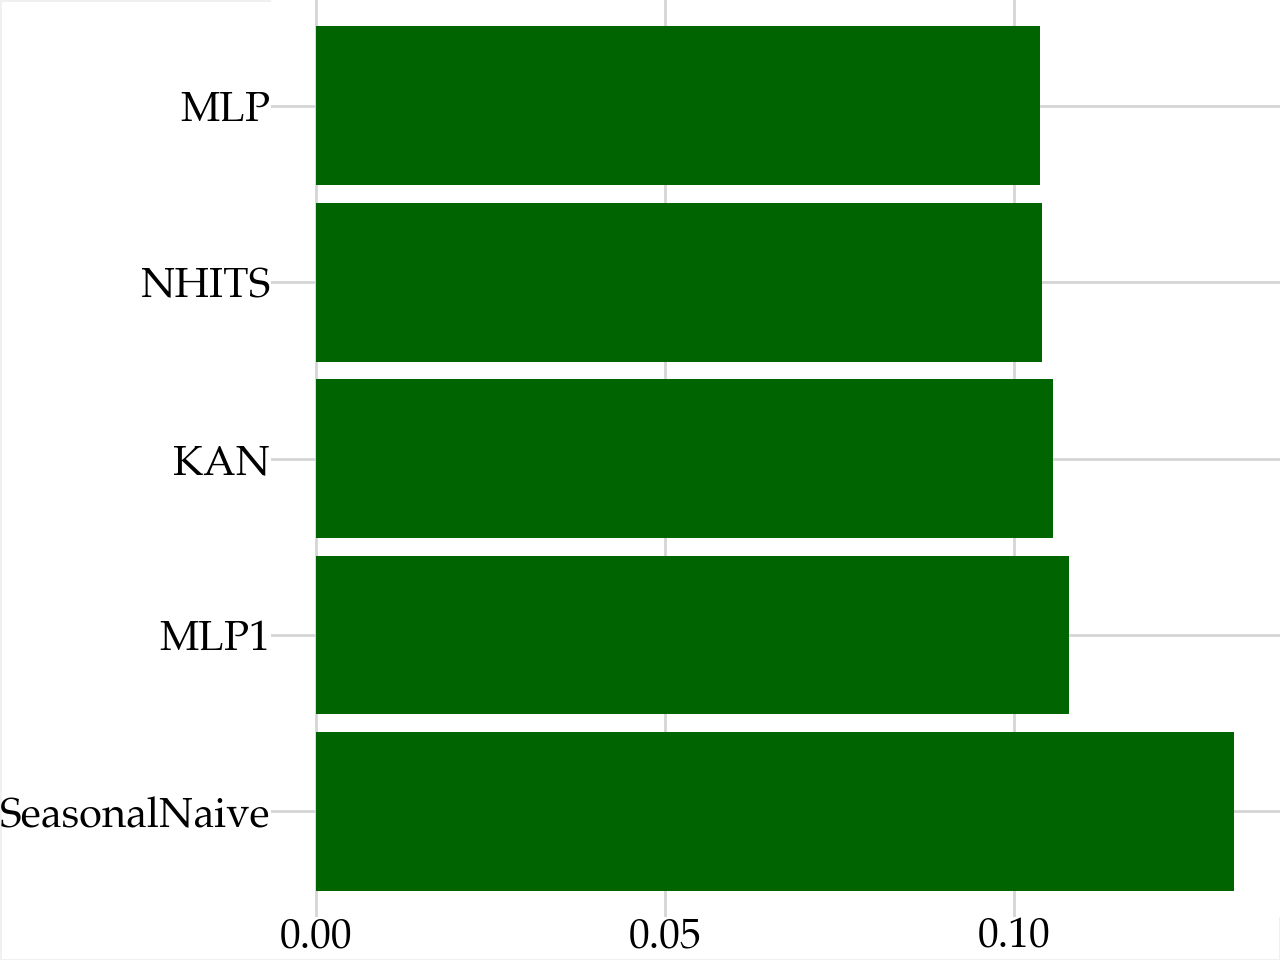

In [8]:
plot = radar.evaluate(return_plot=True, 
                      flip_coords=True,
                      extra_theme_settings=p9.theme(plot_margin=0,
                                                     axis_text=p9.element_text(size=15,
                                                                               colour='black',
                                                                               weight='bold'),
                                                     axis_title_x=p9.element_blank()), )

plot

In [9]:
# pass return_plot=False to get the actual scores
eval_overall = radar.evaluate(return_plot=False)
eval_overall

NHITS            0.103926
MLP              0.103718
MLP1             0.107780
KAN              0.105538
SeasonalNaive    0.131472
Name: Overall, dtype: float64

### Evaluation across forecasting horizons

This analysis shows how model performance changes as the forecast horizon increases. The output includes:
- A DataFrame with error metrics for each model at each horizon
- A line plot showing how errors evolve over increasing horizons

This reveals whether some models maintain their performance advantage at longer horizons or if different models excel at different forecast distances.

#### Accuracy by horizon bound

We can split the analysis by forecasting horizon to check if relative performances are stable across this dimension.

While MLP shows the best overall score, the other neural models outperform it on a multi-step ahead forecasting setting.

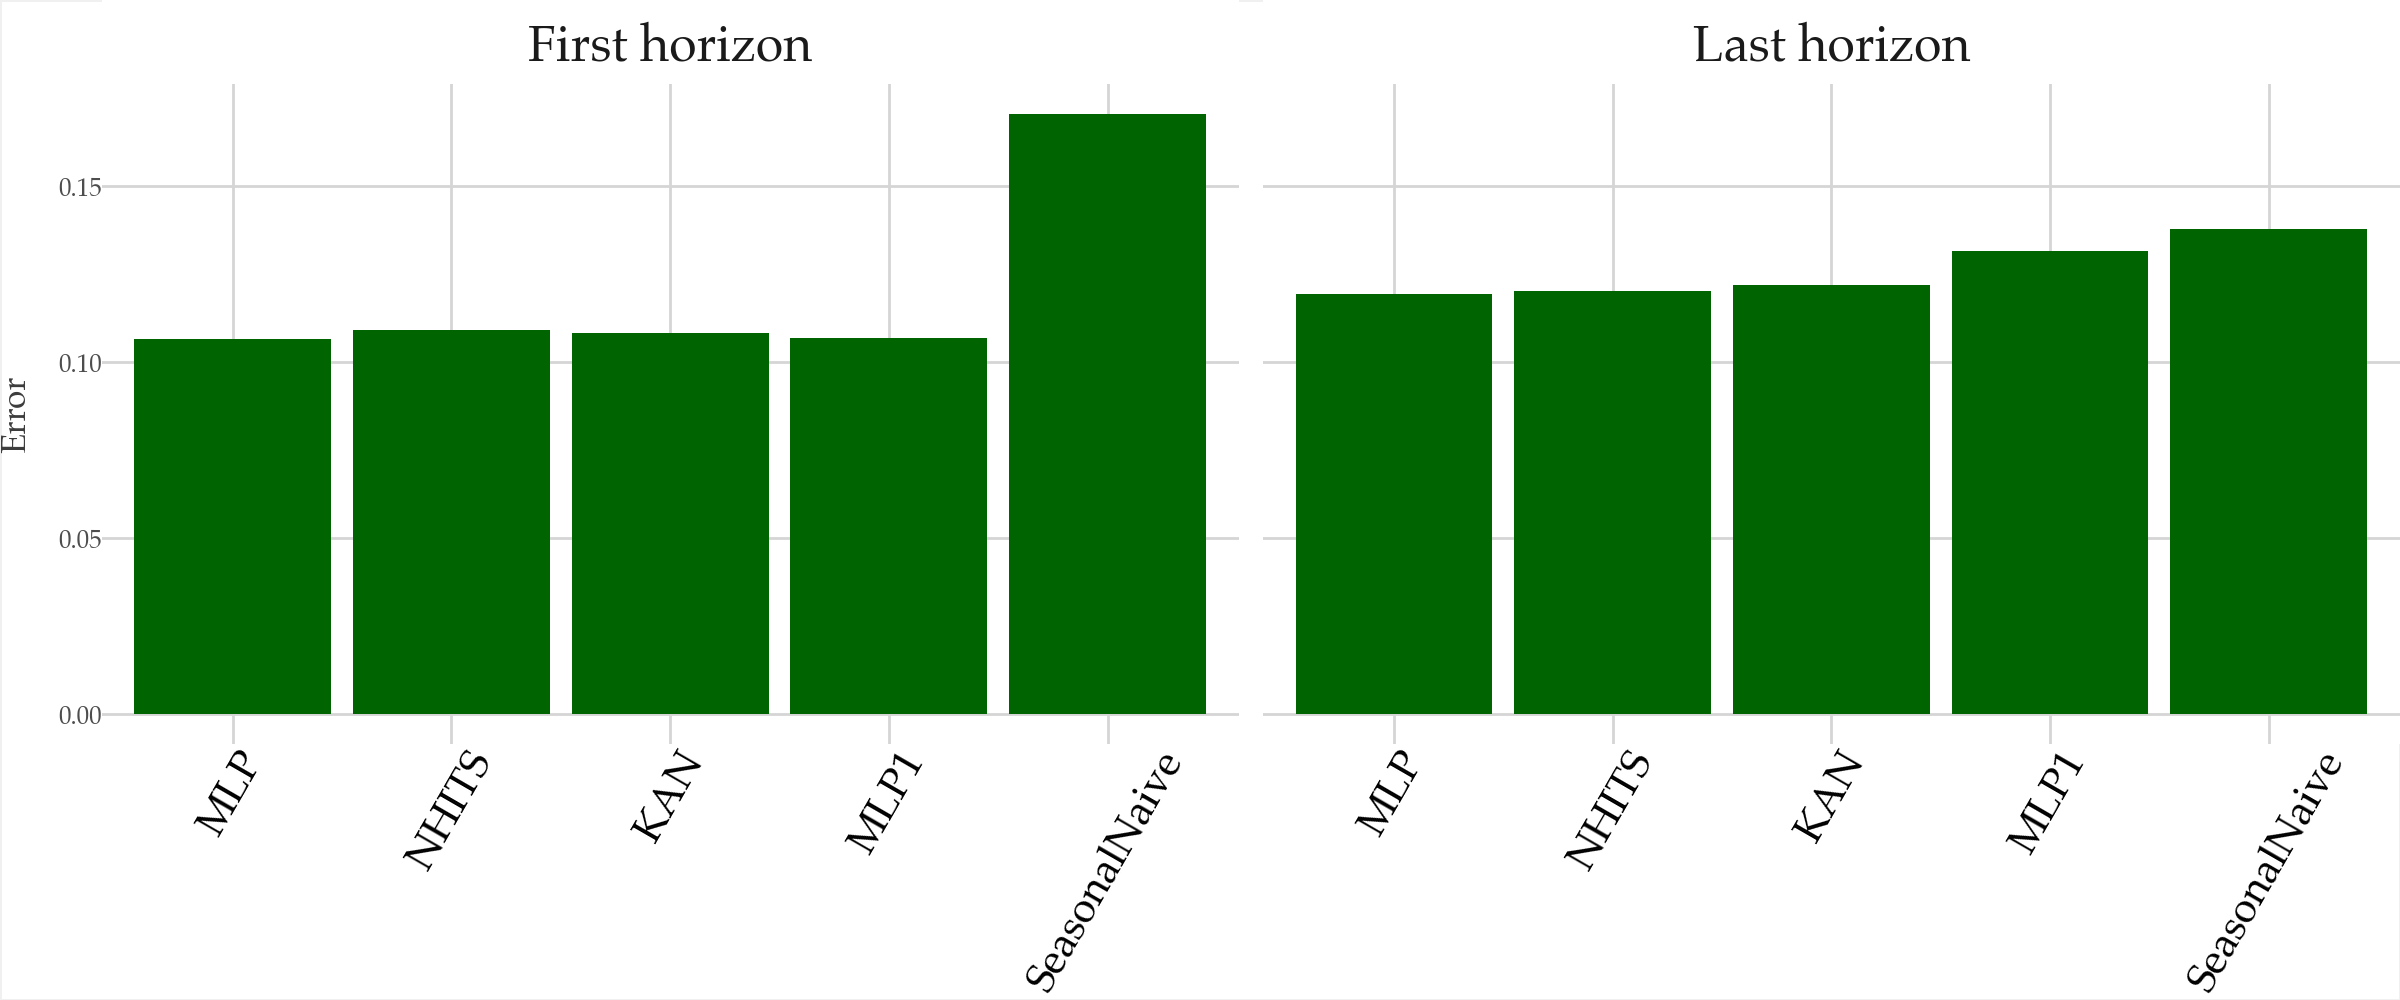

In [10]:
plot = radar.evaluate_by_horizon_bounds(return_plot=True, 
                                        plot_model_cats=radar.model_order, 
                                        extra_theme_settings=p9.theme(plot_margin=0,
                                                               strip_text=p9.element_text(size=18),
                                                               axis_text_x=p9.element_text(size=15,
                                                                                           angle=60,
                                                                                           colour='black',
                                                                                           weight='bold'),
                                                               axis_title_x=p9.element_blank()))

plot + p9.theme(figure_size= (12,5))

In [11]:
# getting the scores without plotting
eval_hbounds = radar.evaluate_by_horizon_bounds()
eval_hbounds

,First horizon,Last horizon
Model,,
NHITS,0.109337,0.120247
MLP,0.106710,0.119563
MLP1,0.107053,0.131621
KAN,0.108487,0.121960
SeasonalNaive,0.170502,0.137894


#### Accuracy across horizon point

The evaluate_by_horizon method shows the accuracy of each model across the forecasting horizon.

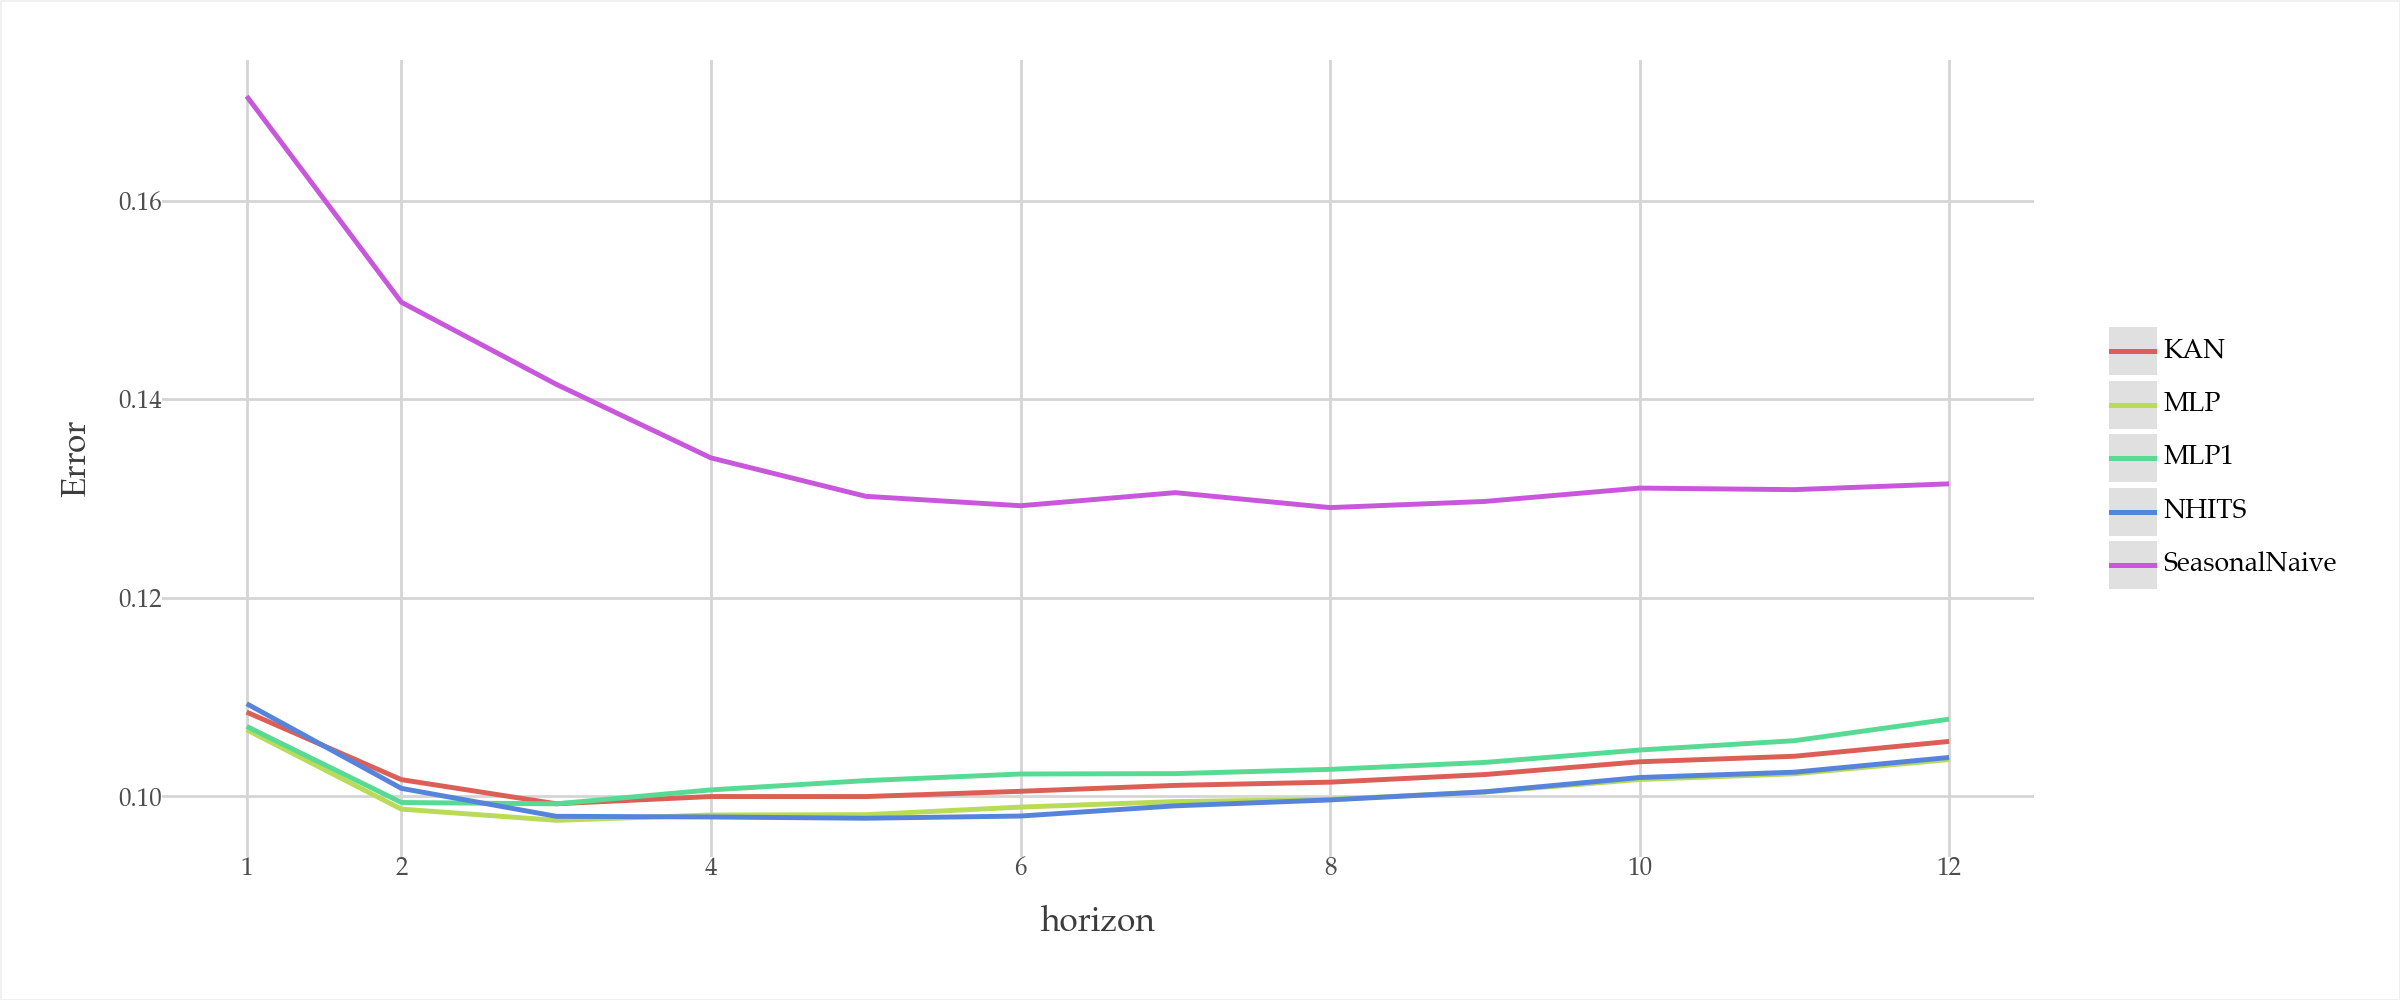

In [12]:
eval_fhorizon = radar.evaluate_by_horizon()

plot = radar.evaluate_by_horizon(return_plot=True)

plot + p9.theme(figure_size= (12,5))

#### Win/loss ratios

Using the performance across time series, you can compute the probability of each event (win/draw/loss) for a given reference model.

While MLP shows the best average accuracy, NHITS has a high probability of outperforming it. The difference in their accuracy is below 10% in about 49% of the time series.

               NHITS loses      draw  NHITS wins
MLP               0.175770  0.490896    0.333333
MLP1              0.223389  0.296218    0.480392
KAN               0.175070  0.472689    0.352241
SeasonalNaive     0.149160  0.179972    0.670868


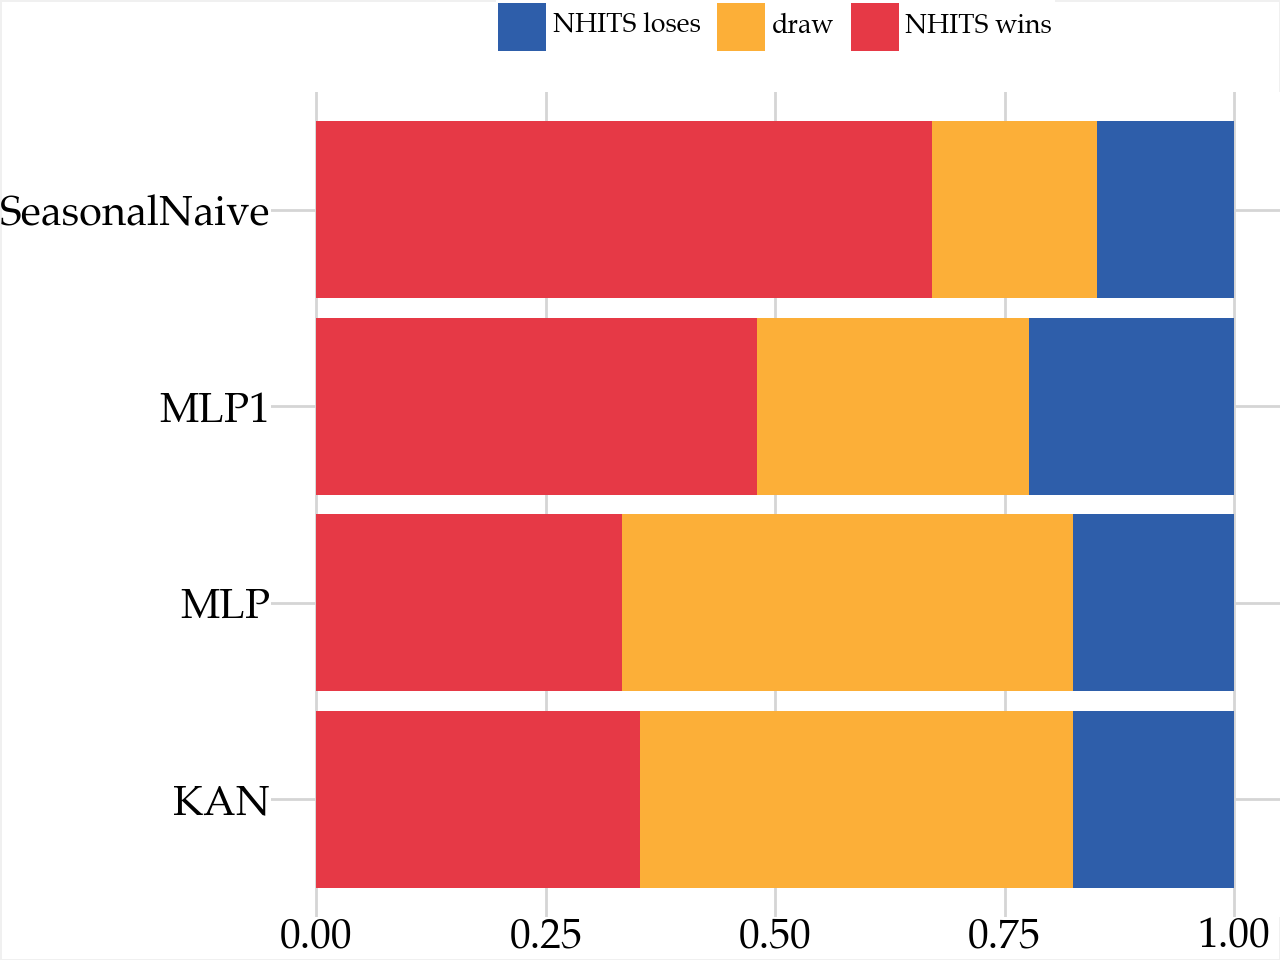

In [13]:
print(radar.rope.get_winning_ratios(err))

plot = radar.rope.get_winning_ratios(err, 
                                     return_plot=True, 
                                     reference=radar.rope.reference,
                                     extra_theme_settings=p9.theme(plot_margin=0,
                                                                    axis_text=p9.element_text(size=15,
                                                                                              colour='black',
                                                                                              weight='bold'),
                                                                    axis_title_x=p9.element_blank()))

plot

#### Win/loss ratios on hard problems

On hard instances (err_hard) NHITS advantage is highlighted. In these cases, KAN is the most competitive model relative to NHITS

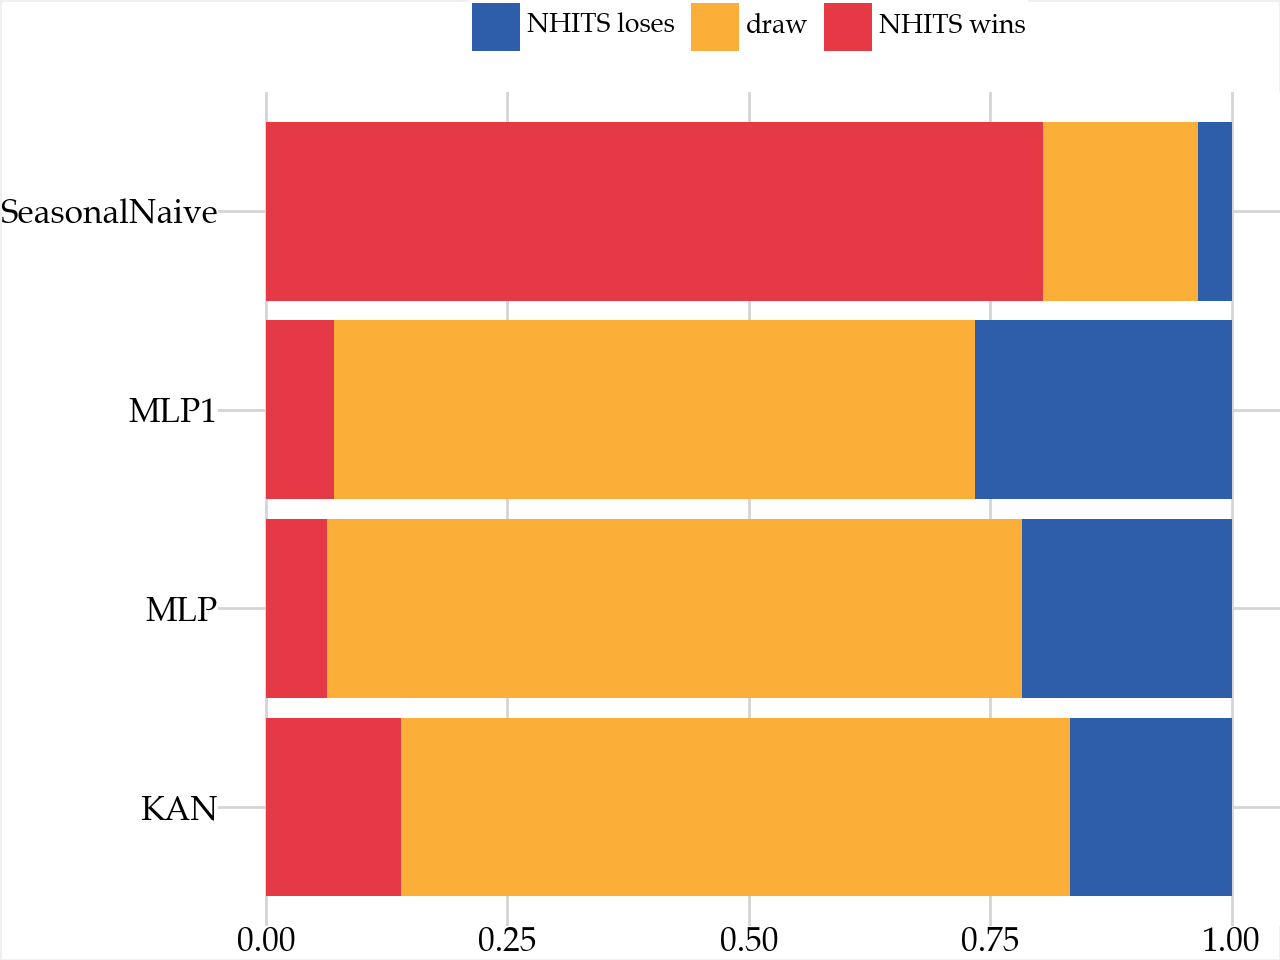

In [14]:
plot = radar.rope.get_winning_ratios(err_hard, 
                                     return_plot=True, 
                                     reference=radar.rope.reference,
                                     extra_theme_settings=p9.theme(plot_margin=0,
                                                                    axis_text=p9.element_text(size=12,
                                                                                              colour='black',
                                                                                              weight='bold'),
                                                                    axis_title_x=p9.element_blank()))

plot

#### Expected shortfall

Another interesting accuracy summary is the expected shortfall, measuring the average accuracy on the worst 95% of cases (of each individual model). From this perspective, NHITS is more susceptible to large errors than other neural models.

NHITS            0.525496
MLP              0.501845
MLP1             0.498763
KAN              0.510183
SeasonalNaive    0.677590
Name: Exp. Shortfall, dtype: float64


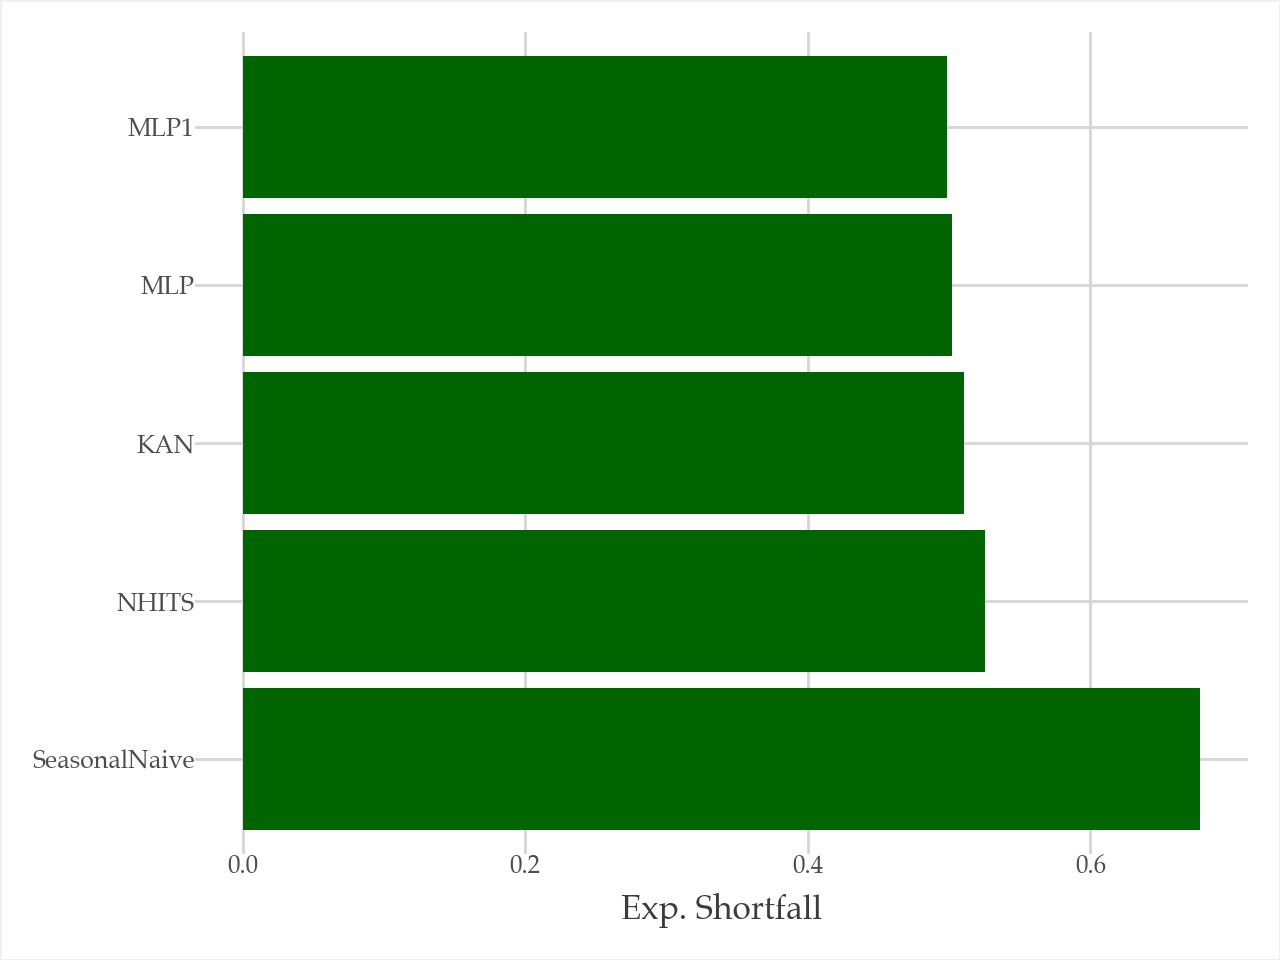

In [15]:
print(radar.uid_accuracy.expected_shortfall(err))

plot = radar.uid_accuracy.expected_shortfall(err, return_plot=True)

plot

#### Evaluation by predefined groups

You can evaluate accuracy controlling for predefined groups. 
Here's an example with the anomaly_status column.

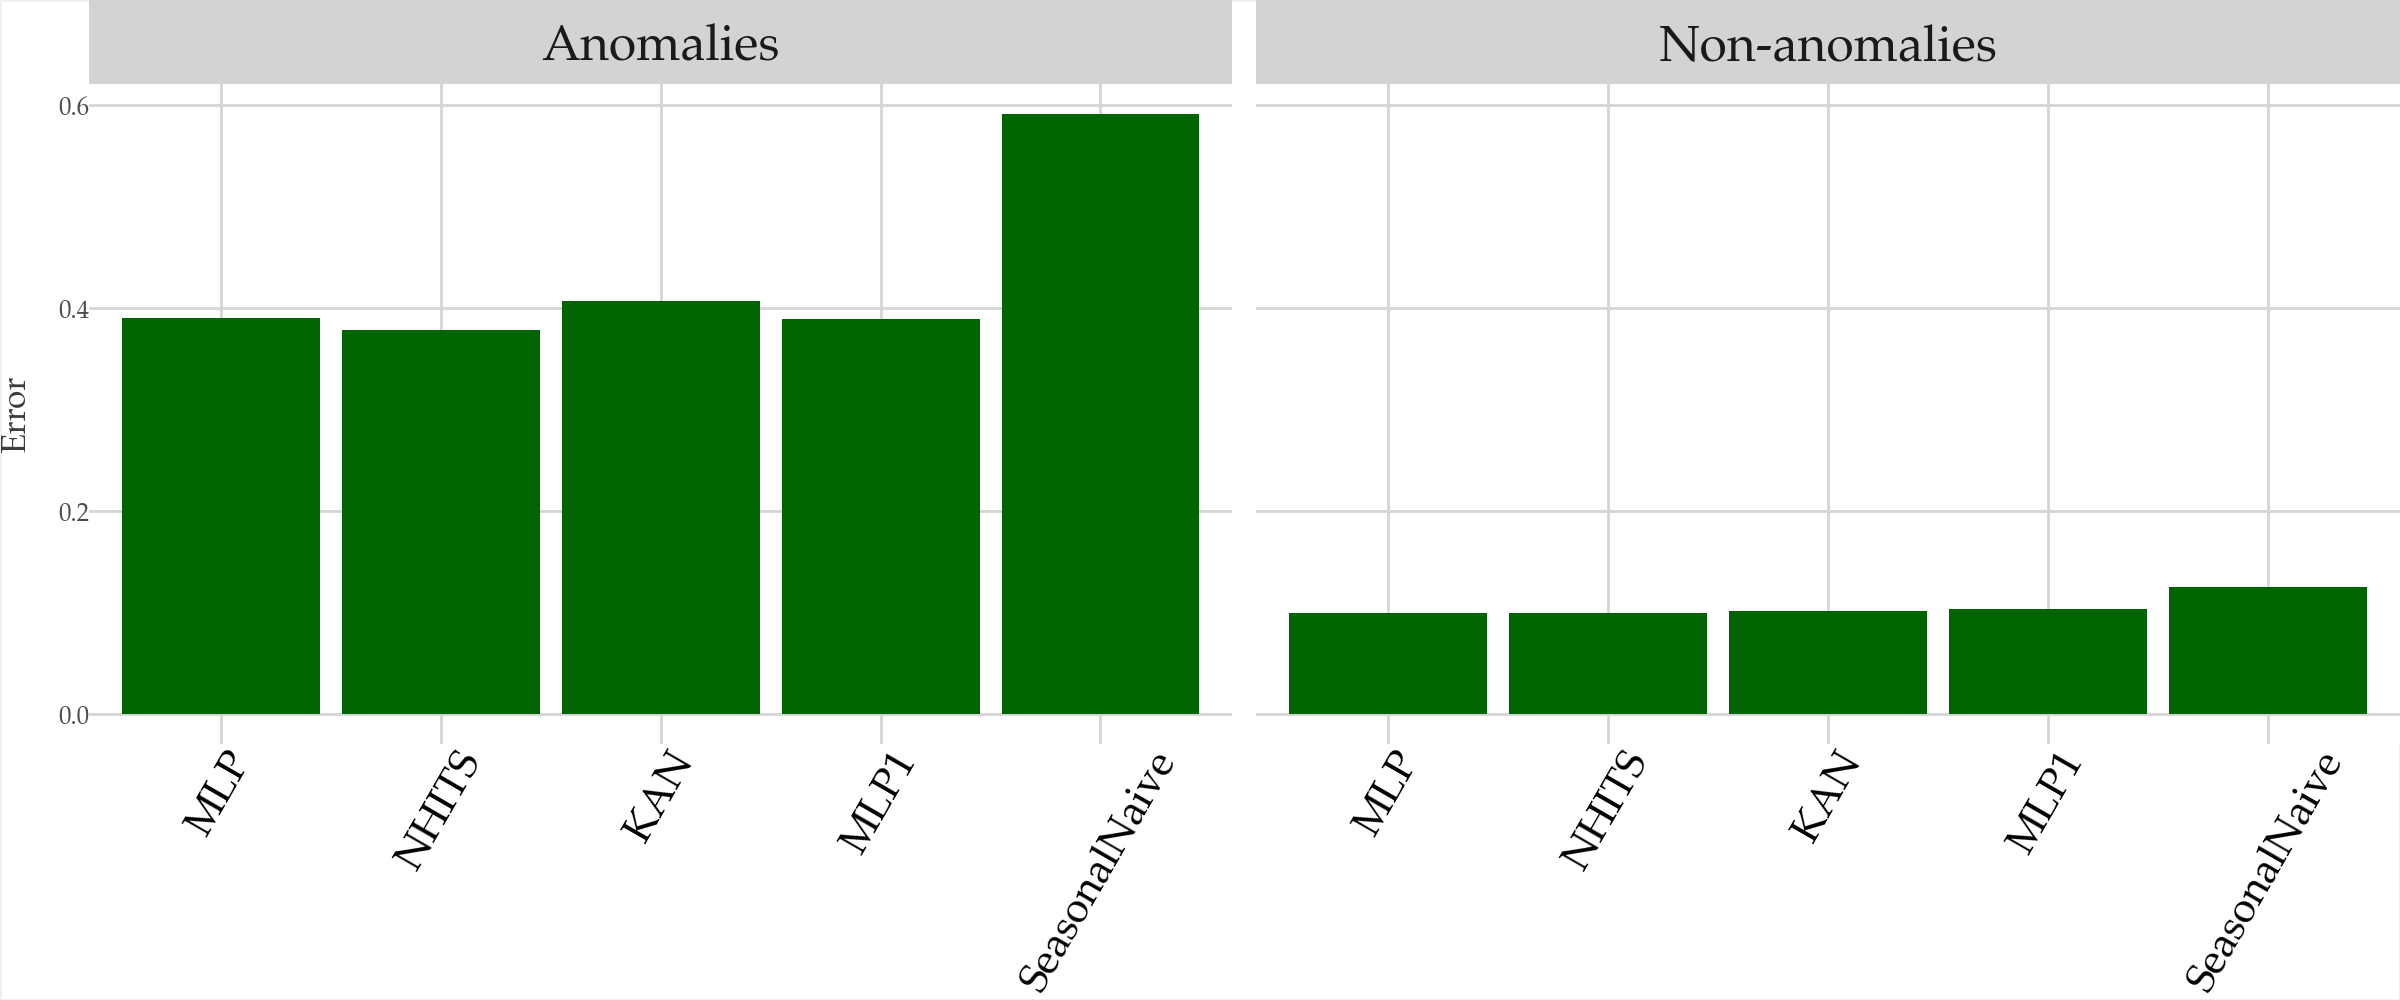

In [16]:
error_on_anomalies = radar.evaluate_by_group(group_col='anomaly_status')

# print(error_on_anomalies)

plot = radar.evaluate_by_group(group_col='anomaly_status', 
                               return_plot=True, 
                               plot_model_cats=radar.model_order, 
                               fill_color='darkgreen',
                              extra_theme_settings=p9.theme(plot_margin=0,
                                                               strip_text=p9.element_text(size=18),
                                                               axis_text_x=p9.element_text(size=15,
                                                                                           angle=60,
                                                                                           colour='black',
                                                                                           weight='bold'),
                                                               axis_title_x=p9.element_blank()))

plot + p9.theme(figure_size= (12,5))

- The main take-away is: When no anomalies are present, all neural approaches perform comparably. Otherwise, MLP1 and NHITS perform the best.

- Finally, you can use ModelRadarPlotter.error_distribution to check the accuracy distribution across unique_ids:

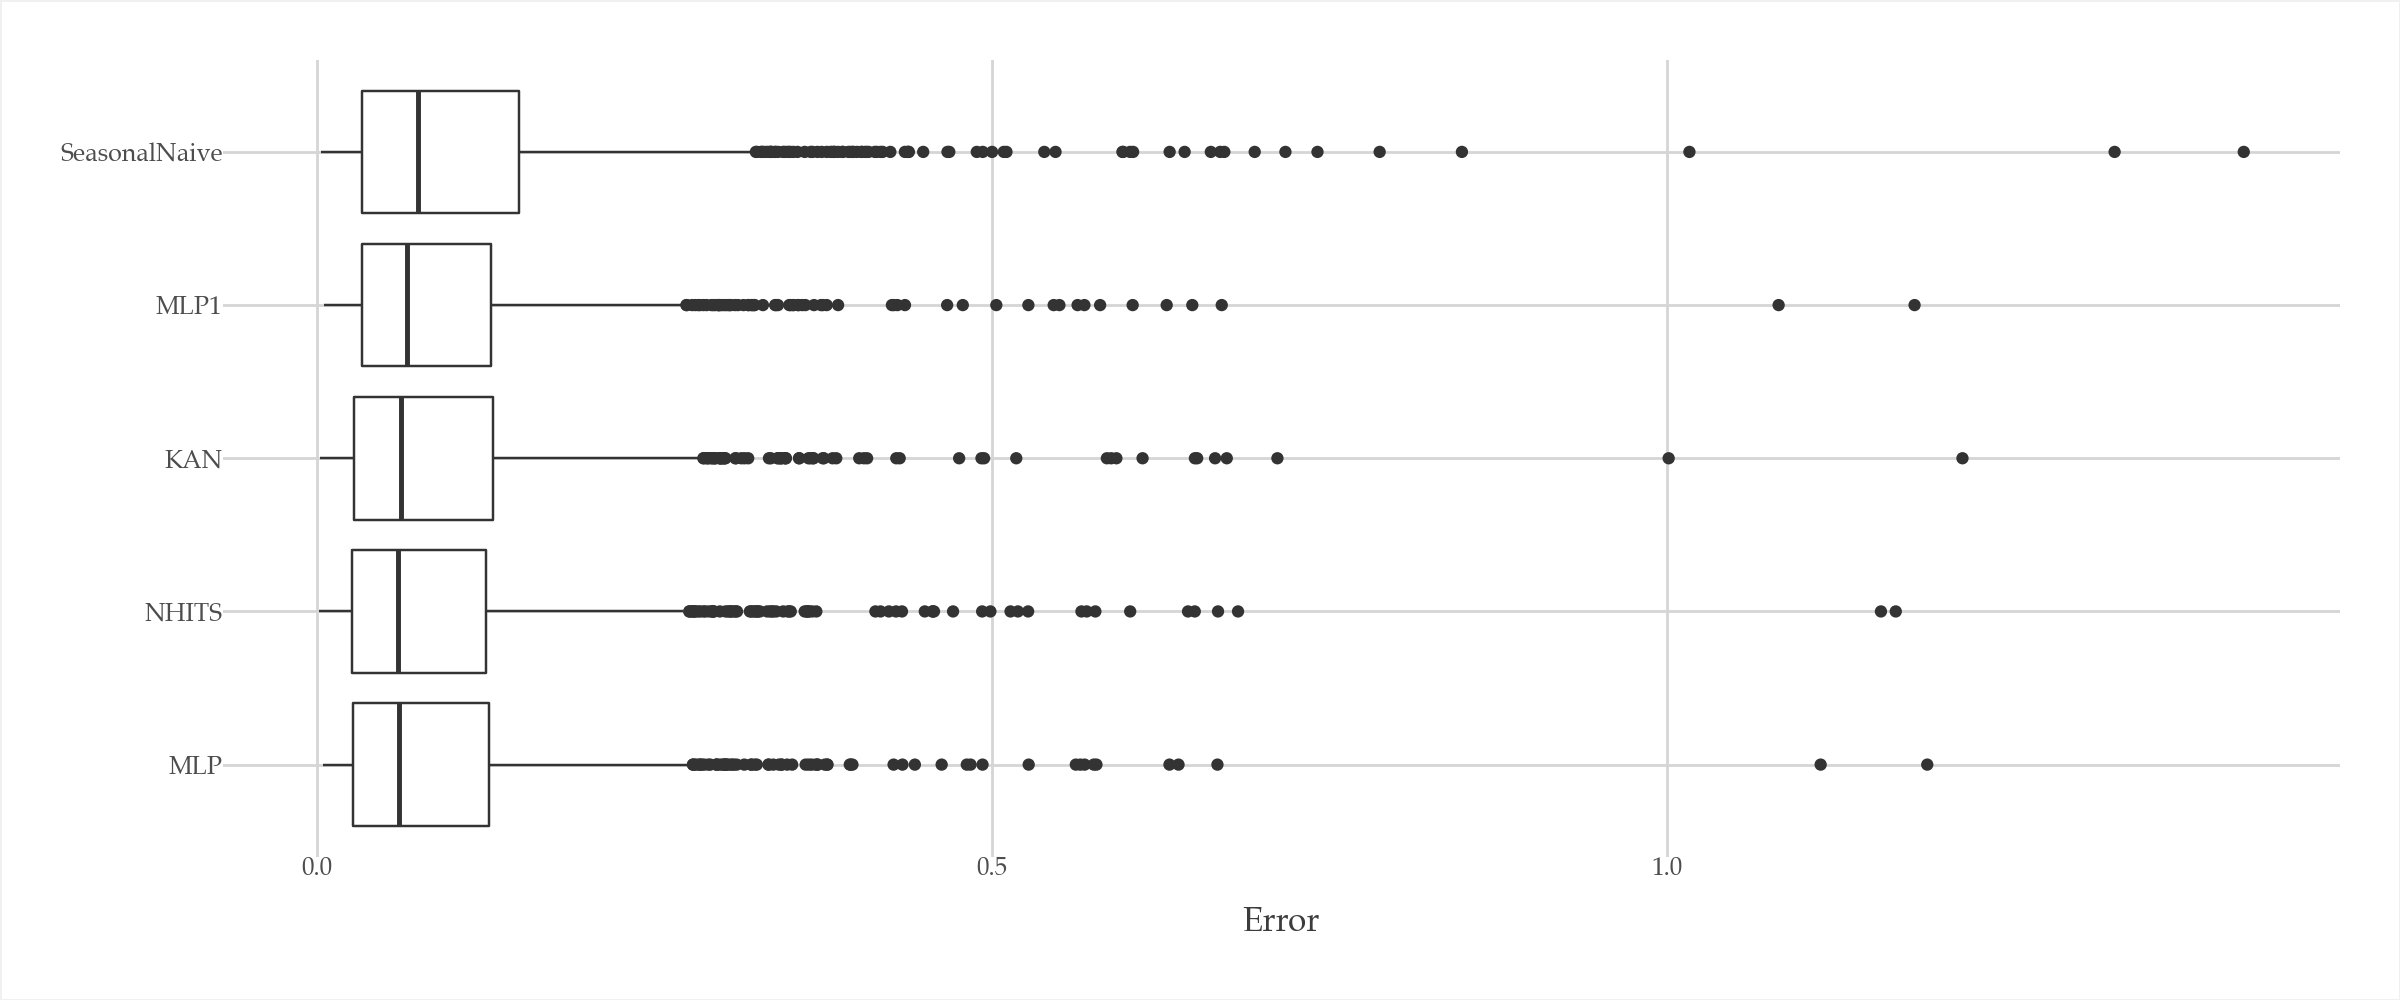

In [17]:
plot = ModelRadarPlotter.error_distribution(data=err, model_cats=radar.model_order, log_transform=True)

plot + p9.theme(figure_size= (12,5))

### Multi-dimension analysis plots

You can combine all analyses into a single plot.

This final visualization summarizes model performance across multiple dimensions:
- Overall performance
- Performance at the first forecast horizon
- Performance at the last forecast horizon
- Performance on anomalous observations
- Performance on hard-to-forecast series

The spider (radar) and parallel coordinate plots provide a holistic view of each model's strengths and weaknesses across different evaluation aspects.

In [18]:
df_plot = pd.concat([eval_overall,
                radar.uid_accuracy.expected_shortfall(err),
                eval_hbounds,
                radar.uid_accuracy.accuracy_on_hard(err),
                error_on_anomalies
                #error_on_trend,
                #error_on_seas
                    ], axis=1)

df_plot.head()

,Overall,Exp. Shortfall,First horizon,Last horizon,On Hard,Anomalies,Non-anomalies
NHITS,0.103926,0.525496,0.109337,0.120247,0.386637,0.378495,0.100266
MLP,0.103718,0.501845,0.106710,0.119563,0.371749,0.390048,0.099713
MLP1,0.107780,0.498763,0.107053,0.131621,0.368002,0.389420,0.103815
KAN,0.105538,0.510183,0.108487,0.121960,0.380465,0.407125,0.101355
SeasonalNaive,0.131472,0.677590,0.170502,0.137894,0.508818,0.591078,0.125067


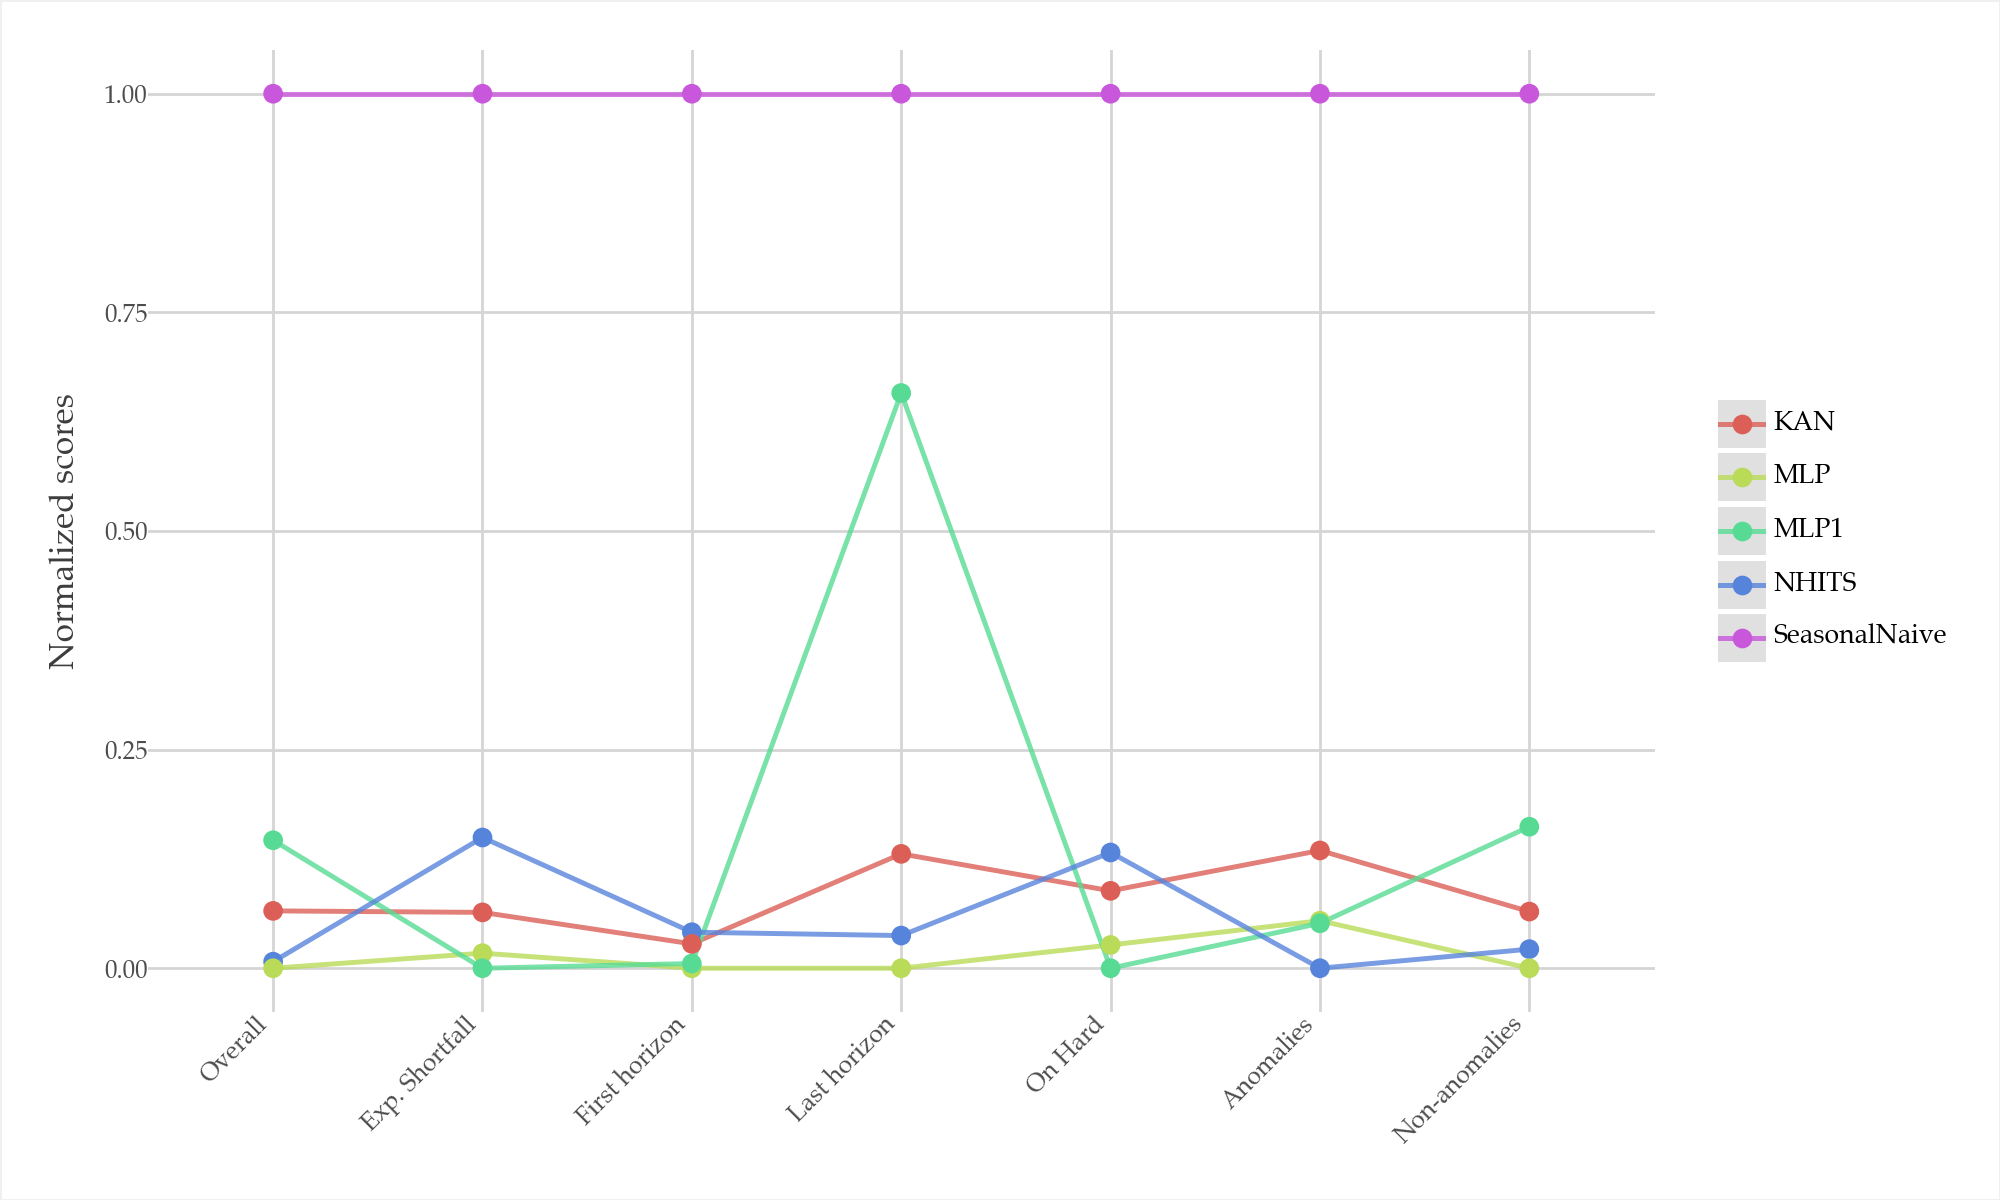

In [19]:
plot = ModelRadarPlotter.multidim_parallel_coords(df_plot, values='normalize')
plot

- In the above plot, we can see that MLP provides the best overall accuracy and where it is outperformed by other models in specific dimensions

- This plot can also be done using ranks (or raw values):

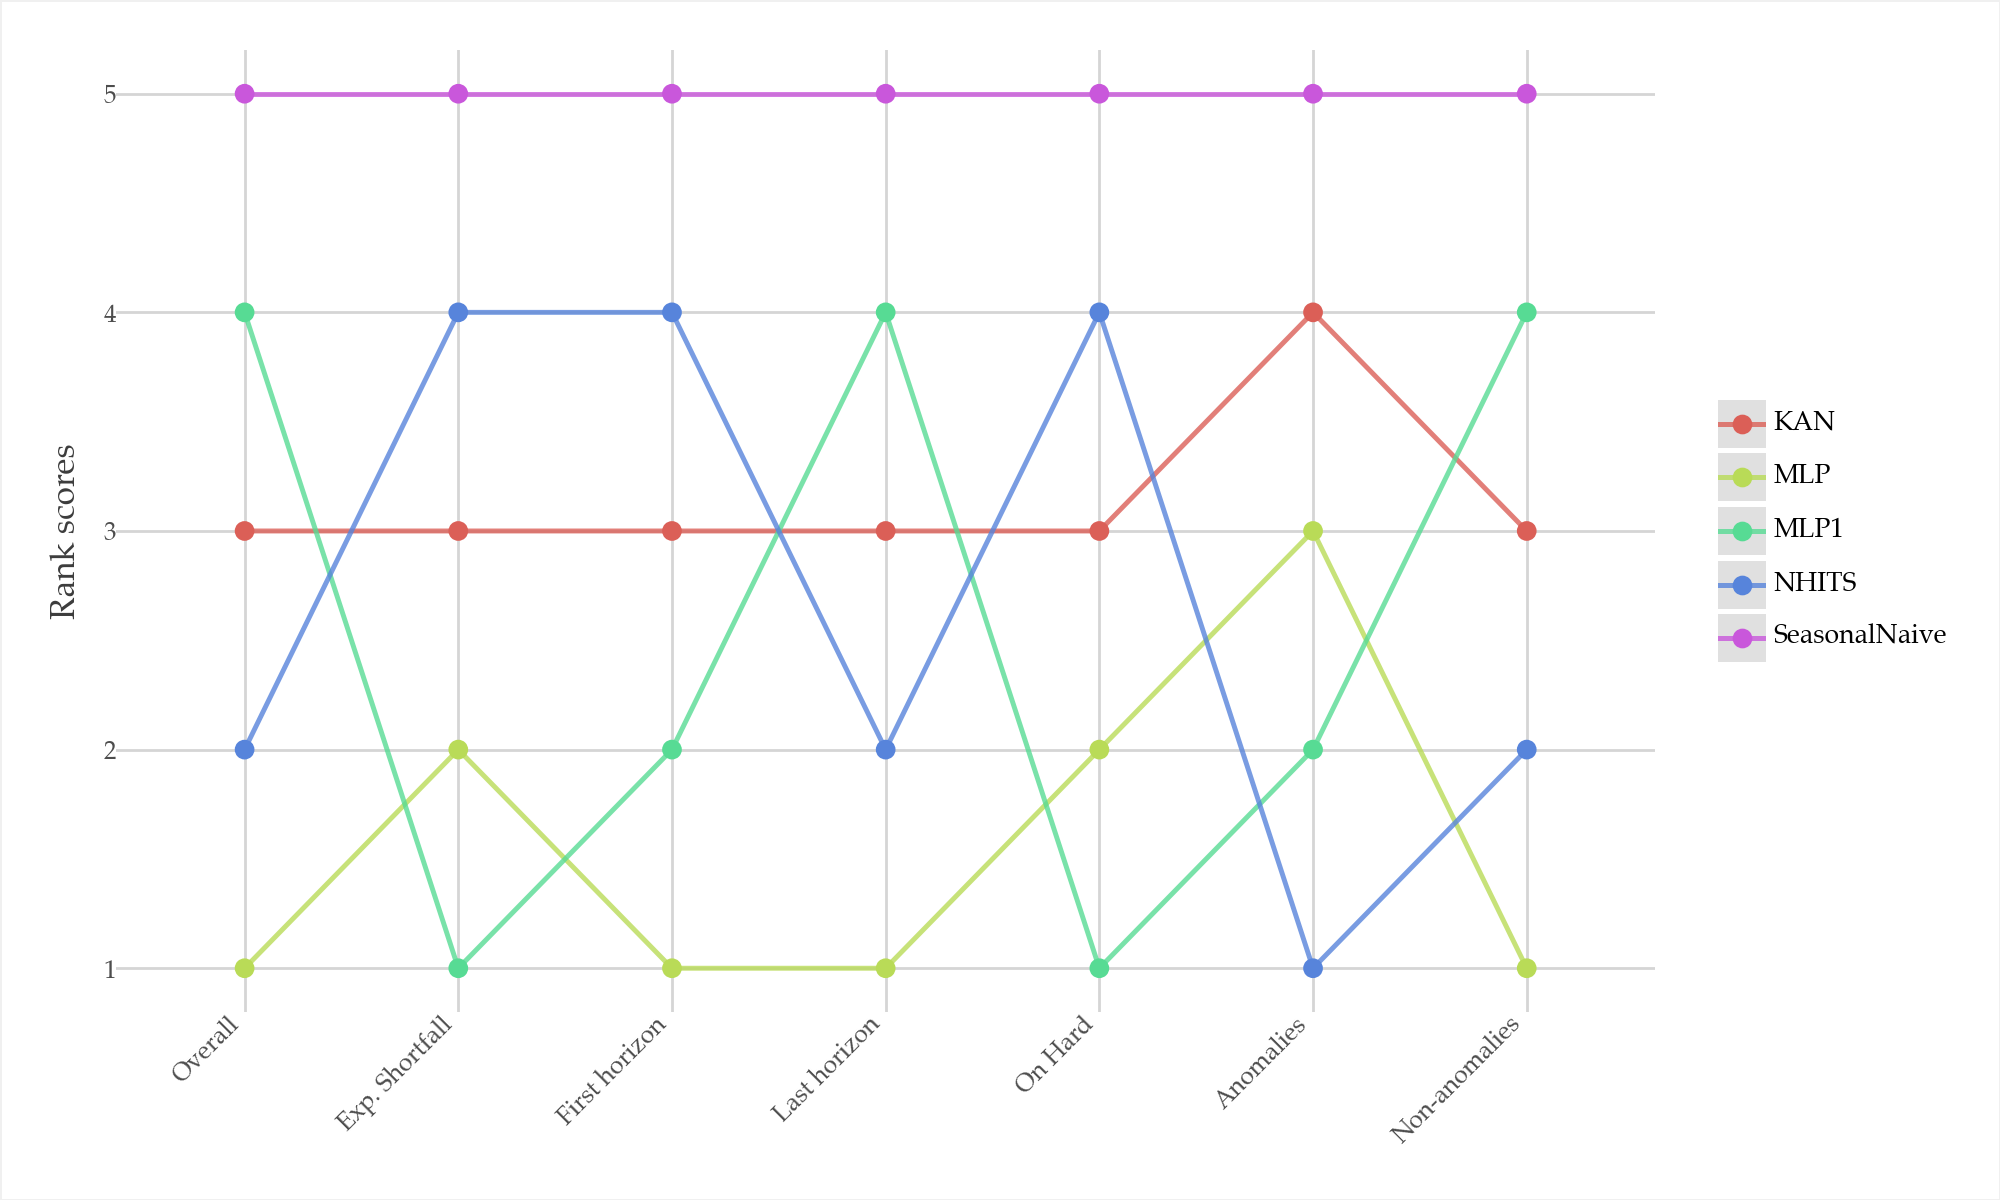

In [20]:
plot = ModelRadarPlotter.multidim_parallel_coords(df_plot, values='rank')
plot

- Spider plots can be used as alternative to parallel coordinate plots:

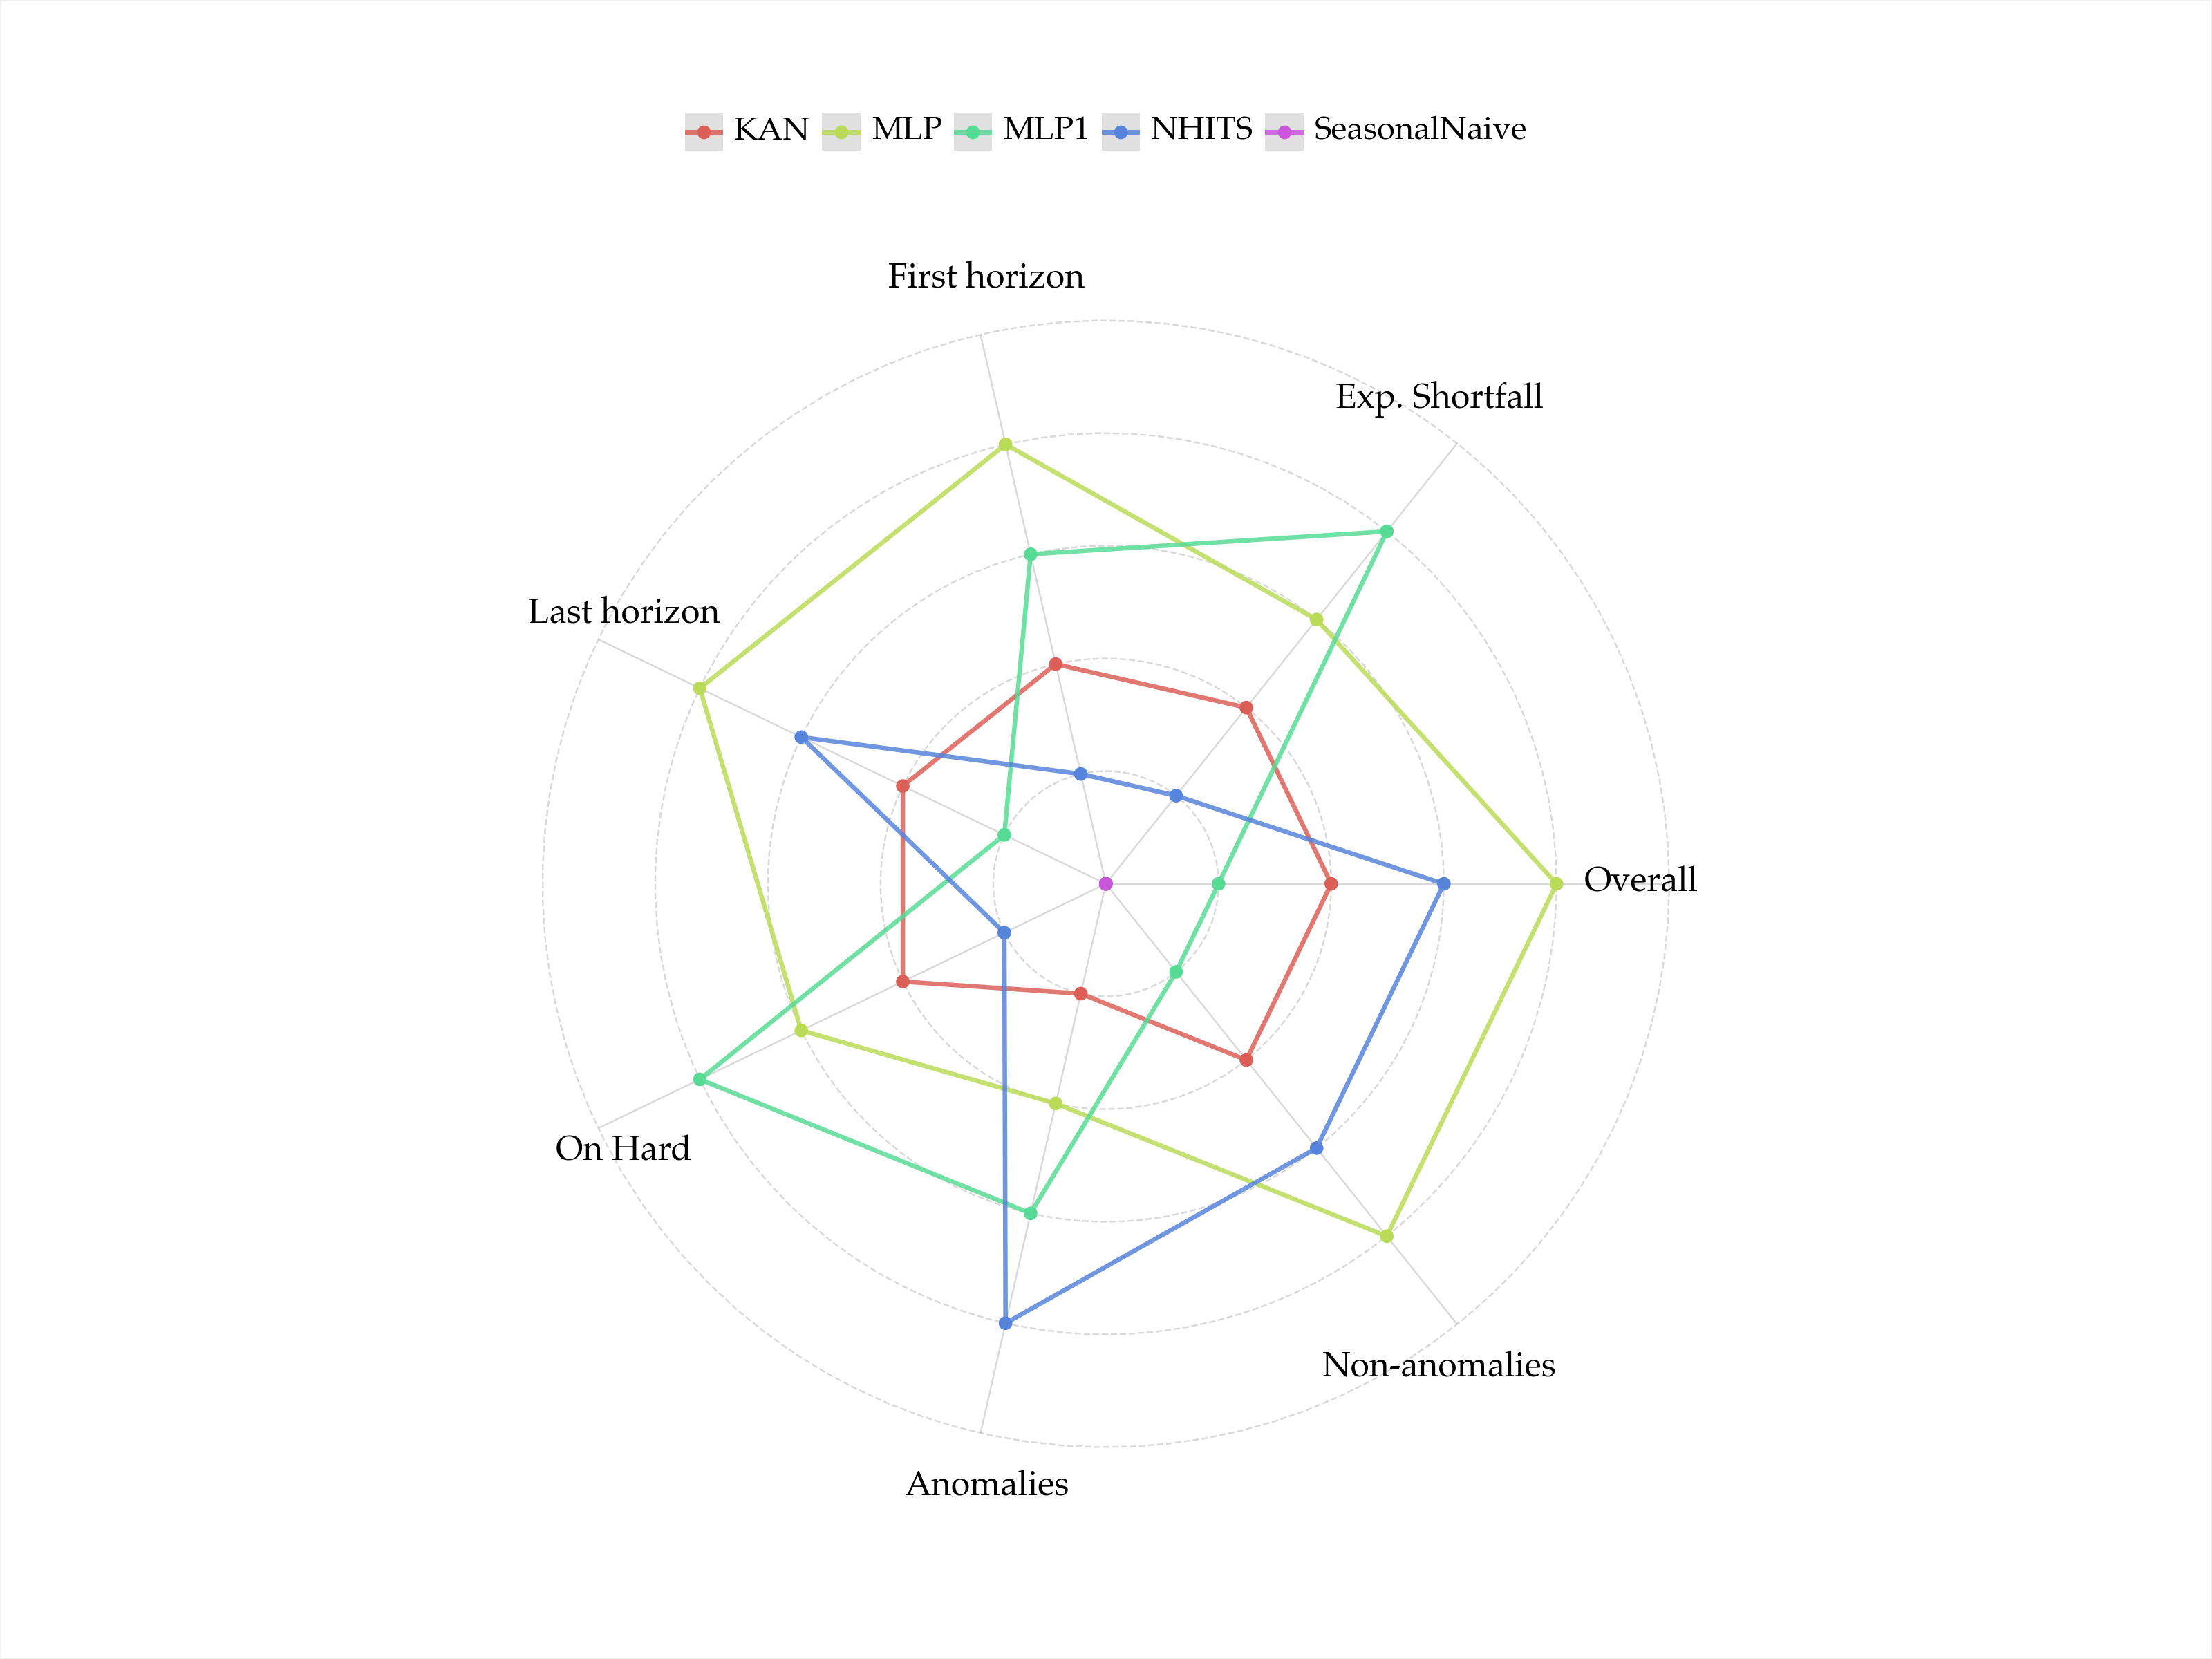

In [21]:
plot = SpiderPlot.create_plot(df=df_plot, values='rank', include_title=False)
plot + p9.theme(plot_margin=0.05,
                figure_size=(16,12),
                legend_position='top',
                legend_text=p9.element_text(size=17),
                legend_key_size=20,
                legend_key_width=20)

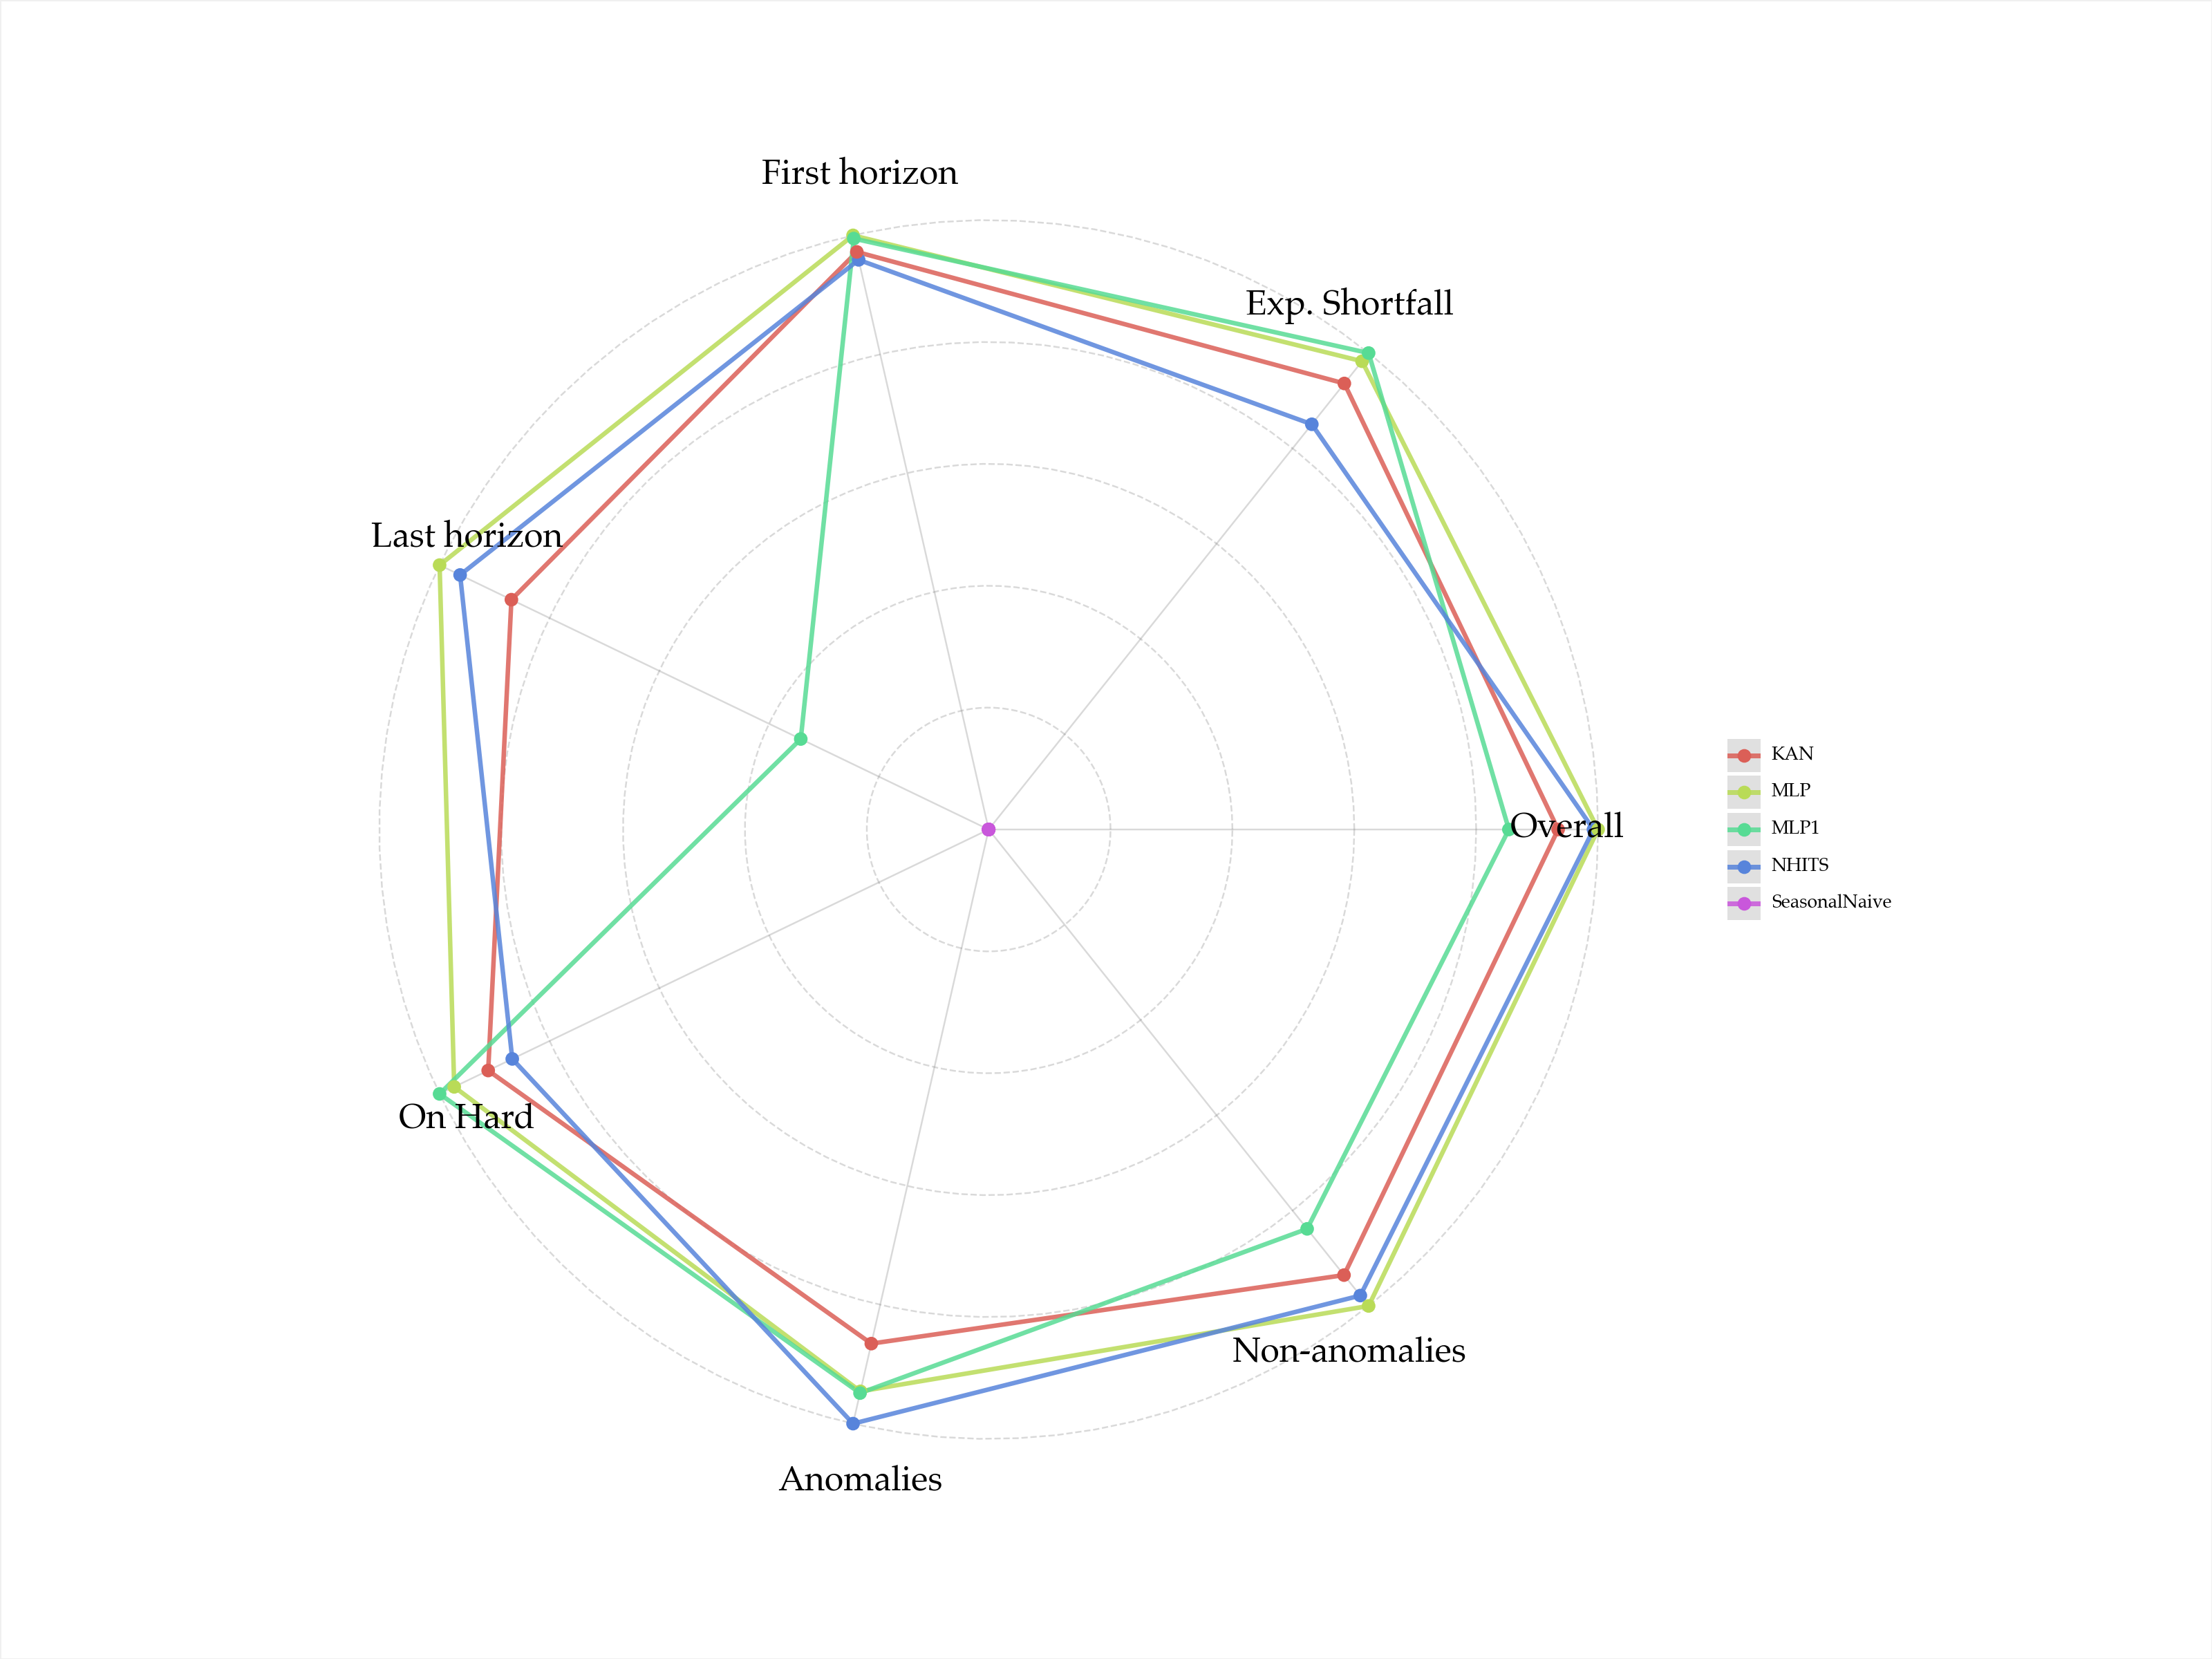

In [22]:
plot = SpiderPlot.create_plot(df=df_plot, values='normalize', include_title=False)
plot + p9.theme(figure_size=(16,12))